In [ ]:
# %%

import sys
import os
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
import astropy.units as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import pickle
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
import xarray

#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f"../data/kcoeff_2020/sonora_2020_feh{mh}_co_{CtoO}.data.196"

#sonora bobcat cloud free structures file
sonora_profile_db = '../data/sonora_bobcat/structures_m+0.0'
sonora_dat_db = '../data/sonora_bobcat/structures_m+0.0'

cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

teff = 250 # Effective Temperature of your Brown Dwarf in K
grav = 316 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

nlevel = 91 # number of plane-parallel levels in your code
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)

nofczns = 1 # number of convective zones initially
nstr_upper = 60 # top most level of guessed convective zone
nstr_deep = nlevel - 2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

def twod_to_threed(arr, reps=4):
    """
    Takes in a 2D array of size (r, c) and repeats it along the last axis to make an array of size (r, c, reps).
    """
    return np.repeat(arr[:, :, np.newaxis], reps, axis=2)

In [ ]:
# %%

print("Setting up atmosphere for cloudless run")
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, cloudy = "cloudless", mh = '0.0', 
                      CtoO = '1.0',species = ['H2O'], fsed = 8.0, beta = 0.1, virga_param = 'const',
                      mieff_dir = "~/projects/clouds/virga/refrind", do_holes = False, fhole = 0.5, fthin_cld = 0.9, moistgrad = False,
                      )

out_cloudless = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Setting up atmosphere for cloudless run
Big iteration is  97.85603010678923 0
Big iteration is  90.05231179059591 1
Profile converged before itmx
Big iteration is  94.4308223887198 0
Big iteration is  90.35596680481072 1
Profile converged before itmx
Big iteration is  85.88141039219786 0
Profile converged before itmx
Big iteration is  87.46816045116333 0
Profile converged before itmx
Move up two levels
Big iteration is  91.82096462766503 0
Big iteration is  100.2175893120913 1
Big iteration is  90.99416407028745 2
Big iteration is  98.85279283202179 3
Profile converged before itmx
Move up two levels
Big iteration is  101.09165523043454 0
Big iteration is  90.71009538434775 1
Big iteration is  103.64103391655557 2
Big iteration is  91.68501808344749 3
Profile converged before itmx
Move up two levels
Big iteration is  93.41235152495668 0
Big iteration is  94.81204614309092 1
Profile converged before itmx
Big iteration is  89.11166182009279 0
Profile converged before itmx
Big iteration is

In [ ]:
# %%

# Restart in order to make a postprocessed/fixed cloud profile
bundle = jdi.inputs(calculation='brown')
bundle.phase_angle(0)
bundle.gravity(gravity=grav, gravity_unit=u.Unit('m/s**2'))
temp, pressure = out_cloudless["temperature"], out_cloudless["pressure"]
bundle.add_pt(temp, pressure)
bundle.premix_atmosphere(opacity_ck, df = bundle.inputs['atmosphere']['profile'].loc[:,['pressure','temperature']])
DTAU, TAU, W0, COSB,ftau_cld, ftau_ray,GCOS2, DTAU_OG, TAU_OG, W0_OG, COSB_OG, \
                    W0_no_raman, surf_reflect, ubar0,ubar1,cos_theta, single_phase,multi_phase, \
                    frac_a,frac_b,frac_c,constant_back,constant_forward, \
                    wno,nwno,ng,nt, nlevel, ngauss, gauss_wts, mmw, gweight,tweight = jdi.calculate_atm(bundle, opacity_ck)
bb, y2, tp = 0, 0, 0
FOPI = np.zeros(opacity_ck.nwno) + 1.0
Teff = cl_run.inputs["planet"]["T_eff"]
min_temp = min(opacity_ck.temps)
max_temp = max(opacity_ck.temps)
if Teff > 300:
    tmin = min_temp*(1-extension)
else:
    tmin = 10
tmax = max_temp*(1.3)
dt = bundle.inputs['climate']['dt_bb_grid']
ntmps = int((tmax-tmin)/dt)
flux_net_v_layer_full, flux_net_v_full, flux_plus_v_full, flux_minus_v_full , flux_net_ir_layer_full, flux_net_ir_full, flux_plus_ir_full, flux_minus_ir_full = jdi.get_fluxes(pressure, temp, opacity_ck.delta_wno, bb , y2, tp, tmin, tmax, DTAU, TAU, W0, 
                    COSB,ftau_cld, ftau_ray,GCOS2, DTAU_OG, TAU_OG, W0_OG, COSB_OG, W0_no_raman, surf_reflect, 
                    ubar0,ubar1,cos_theta, FOPI, single_phase,multi_phase,frac_a,frac_b,frac_c,constant_back,constant_forward, 
                    wno,nwno,ng,nt,gweight,tweight, nlevel, ngauss, gauss_wts,True, True)#True for reflected, True for thermal
mean_molecular_weight = np.mean(mmw)
sigma_sb = 0.56687e-4
tidal = np.zeros_like(pressure) - sigma_sb *(Teff**4)
grad = bundle.inputs["climate"]["grad"]
cp = bundle.inputs['climate']['cp']
nstr = out_cloudless["cvz_locs"]
kzz = jdi.get_kzz(
    out_cloudless["pressure"], out_cloudless["temperature"],grav,mmw,tidal,flux_net_ir_layer_full, flux_net_ir_layer_full,
    cl_run.inputs["climate"]["t_table"], cl_run.inputs["climate"]["p_table"], cl_run.inputs["climate"]["grad"], cl_run.inputs["climate"]["cp"],
    0,list(nstr),bundle.inputs['atmosphere']['profile'].T.values
)
# this virga run will use the cloudless-converged temperature profile
# and the associated Kzz
bundle.inputs['atmosphere']['profile']['temperature'] = temp
bundle.inputs['atmosphere']['profile']['kz'] = kzz

print("Making clouds off cloudless run for post-processed/fixed")
postproc_cld_out = bundle.virga(["H2O"],"~/projects/clouds/virga/refrind", fsed=8.0,mh=1.0,mmw = mean_molecular_weight, b = 0.1, param = 'const')
postproc_cld_df = vj.picaso_format(postproc_cld_out["opd_per_layer"], postproc_cld_out["single_scattering"], postproc_cld_out["asymmetry"], postproc_cld_out["pressure"], 1e4 / postproc_cld_out["wave"])

cl_run.inputs["climate"]["cloudy"] = "fixed"
cl_run.inputs["climate"]["opd_climate"] = twod_to_threed(postproc_cld_out["opd_per_layer"])
cl_run.inputs["climate"]["w0_climate"] = twod_to_threed(postproc_cld_out["single_scattering"])
cl_run.inputs["climate"]["g0_climate"] = twod_to_threed(postproc_cld_out["asymmetry"])

print("Fixed run")
out_fixed = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Making clouds off cloudless run for post-processed/fixed
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Fixed run
Big iteration is  97.06232700518827 0
Profile converged before itmx
Big iteration is  92.40291492140159 0
Profile converged before itmx
Big iteration is  95.66849598155119 0
Profile converged before itmx
final [ 0 49 89  0  0  0]
In t_start: Converged Solution in iterations  6
 We are already at a root, tolf , test =  5e-05 ,  2.1805357567501103e-05
 We are already at a root, tolf , test =  5e-05 ,  2.1805357567501103e-05
 We are already at a root, tolf , test =  5e-05 ,  2.1805357567501103e-05
 We are already at a root, tolf , test =  5e-05 ,  2.1805357567501103e-05
YAY ! ENDING WITH CONVERGENCE


In [ ]:
#%%

print("Self-consistent run")
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, cloudy = "selfconsistent", mh = '0.0', 
                      CtoO = '1.0',species = ['H2O'], fsed = 8.0, beta = 0.1, virga_param = 'const',
                      mieff_dir = "~/projects/clouds/virga/refrind", do_holes = False, fhole = 0.5, fthin_cld = 0.9, moistgrad = False,
                      )
cl_run.inputs["climate"]["guess_temp"][np.isnan(out_fixed["temperature"])] = out_fixed["temperature"][0]

out_selfconsistent = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Self-consistent run
Cloudy functionality still in beta form and not ready for public use.
 We are already at a root, tolf , test =  5e-05 ,  2.7169757057909577e-05
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Max TAUCLD diff is 0.0  Tau tolerance is  0.47601633100690127
Big iteration is  69.02250889486814 0
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Max TAUCLD diff is 0.0  Tau tolerance is  4.280840122600548
Big iteration is  77.23520472346001 1
 We are already at a root, tolf , test =  5e-05 ,  2.347802636164395e-05
Overwriting some Kz values to minimum value set by kz_min 
                     You can always turn off these warnings by setting verbose=False
Max TAUCLD diff is 0.0  Tau tolerance is  8.363192589579892
Big iteration is  141.68155465226997 2
In t_start: Converged Solution in 

In [ ]:
# %%

def calculate_spectrum(out, cld_out):
    opa_mon = jdi.opannection()

    hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
    grav = 316 # Gravity of your brown dwarf in m/s/s
    hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

    hi_res.atmosphere(df=out['ptchem_df'])
    if cld_out is not None:
        hi_res.clouds(df=cld_out)

    df_spec1 = hi_res.spectrum(opa_mon, calculation='thermal', full_output= True)

    wno, fp = df_spec1['wavenumber'], df_spec1['thermal'] #erg/cm2/s/cm
    xmicron = 1e4/wno

    flamy = fp*1e-8  
    sp = jdi.psyn.ArraySpectrum(xmicron, flamy,
                            waveunits='um',
                            fluxunits='FLAM')
    sp.convert("um")
    sp.convert('Fnu')  # erg/cm2/s/Hz

    wno = sp.wave  # micron
    fp = sp.flux  # erg/cm2/s/Hz
    df_spec1['fluxnu'] = fp
    wno,fp = jdi.mean_regrid(1e4/wno,fp, R=200)
    return wno, fp

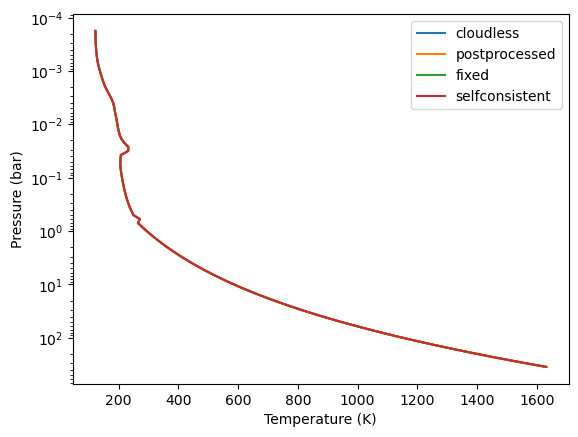

In [ ]:
# %%

for (out, run_name) in zip(
    [out_cloudless, out_cloudless, out_fixed, out_selfconsistent],
    ["cloudless", "postprocessed", "fixed", "selfconsistent"]
):
    plt.semilogy(out["temperature"], out["pressure"], label=run_name)
    
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.gca().invert_yaxis()
plt.legend()
plt.show()

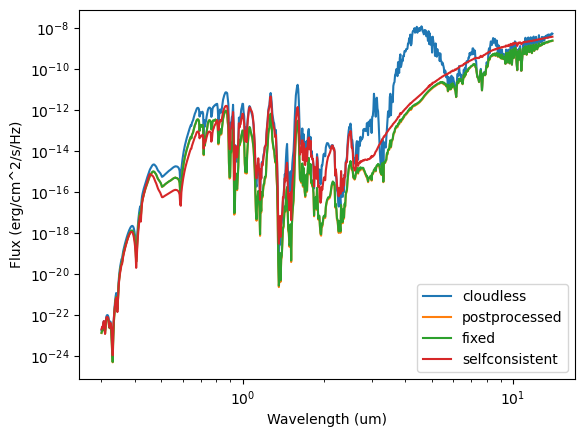

In [ ]:
# %%

for (out, cld_out, run_name) in zip(
    [out_cloudless, out_cloudless, out_fixed, out_selfconsistent],
    [None, postproc_cld_df, postproc_cld_df, out_selfconsistent['cld_output_picaso']],
    ["cloudless", "postprocessed", "fixed", "selfconsistent"]
):
    wno, fp = calculate_spectrum(out, cld_out)
    plt.loglog(1e4/wno, fp, label=run_name)
    np.save(f"../data/four_clouds_testing/wno_{run_name}.npy", wno)
    np.save(f"../data/four_clouds_testing/fp_{run_name}.npy", fp)

plt.xlabel("Wavelength (um)")
plt.ylabel("Flux (erg/cm^2/s/Hz)")
plt.legend()
plt.show()